# Project 1

# Are global warming and climate change supported by data? How did land temperatures change following major  innovations in transportation? How is this rate different in different places around the world?

Faisal Alkhalili


1004723427


ECO225

## Introduction

This research project aims to use records of the average land temperatures around the world categorized globally, by country, and by city to investigate whether climate change and global warming are supported by data. There will also be a focus on warming effect of different milestones in the development of transportation technology. Essentially, this research will look at how the rate of the rise of land temperatures has generally changed over since 1750 and how it changed immediately following the widespread use of new transportation technologies. The key is to examine how this rate is different in the period preceding the adoption of a certain new mode of transportation and immediately after it. The two primary events that will be isolated are the widespread use of the car (it was patented in 1886) and, subsequently, the aircraft (began to be used commercially in 1914).

The data that will be used is sourced from Berkeley Earth, an agency that has made several archives of environmental data avialable. The data contains monthly land temperature recordings that begin in 1750. After the year 1850, the data started included maximum and minimum values for each month. Some subsets of the data contain the monthly land temperature values categorized according to the country, city, major city, and US state. It's important to consider that this data begins around the same time that the Industrial Revolution is thought to have started. This is generally considered as the time that industrial pollution began to have seriously adverse effects on the climate and the temperature of the Earth. The outcome that is being considered in this research is the change in the average land temperature and the two main independent variables are pollution generally (which is essentially represented by time), the adoption of new transportation technologies, and the distance of each major city from the equator.

## Raw Data

In [1]:
data_url = "https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data"

In [2]:
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm #for linear regression: sm.ols
import geopandas as gpd

from shapely.geometry import Point

from pandas_datareader import DataReader

%matplotlib inline
#activate plot theme
import qeds
qeds.themes.mpl_style();
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [3]:
#Reading the first dataset, Global average land temperatures.
glob_land_temp = pd.read_csv('~/Desktop/School/UofT/Third Year/ECO225/ECO225 Project 1/GlobalTemperatures.csv')

In [4]:
#Turning the first dataset into a dataframe. The data is cleaned by dropping irrelevant columns.
glob_df = pd.DataFrame(glob_land_temp)
glob_df = glob_df.drop(['LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 
                        'LandMinTemperature', 'LandAndOceanAverageTemperatureUncertainty', 
                        'LandMinTemperatureUncertainty','LandAndOceanAverageTemperature'], axis=1)
glob_df

,dt,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573
...,...,...
3187,2015-08-01,14.755
3188,2015-09-01,12.999
3189,2015-10-01,10.801
3190,2015-11-01,7.433


In [5]:
#Creating a new column in the dataframe glob_df that finds the percent change 
#in the average global land temperature, month over month.
glob_df['percent change in temp'] = glob_df['LandAverageTemperature'].pct_change()
glob_df['percent change in temp'] = glob_df['percent change in temp'] * 100
glob_df['percent change in temp'] = glob_df['percent change in temp'].round(2)
glob_df

,dt,LandAverageTemperature,percent change in temp
0,1750-01-01,3.034,NaN
1,1750-02-01,3.083,1.62
2,1750-03-01,5.626,82.48
3,1750-04-01,8.490,50.91
4,1750-05-01,11.573,36.31
...,...,...,...
3187,2015-08-01,14.755,-1.97
3188,2015-09-01,12.999,-11.90
3189,2015-10-01,10.801,-16.91
3190,2015-11-01,7.433,-31.18


The table above represents the raw data for the average global land temperature, per month, since 1750. This is going to be this research's main source of information for the global average land temperature.

In [6]:
#Reading the second dataset, monthly average land temperatures by major city. 
#The data is cleaned and irrelevant columns are dropped.
city_land_temp = pd.read_csv('~/Desktop/School/Uoft/Third Year/ECO225/ECO225 Project 1/GlobalLandTemperaturesByMajorCity.csv')
city_df = pd.DataFrame(city_land_temp)
city_df = city_land_temp.drop(['AverageTemperatureUncertainty', 'Longitude'], axis=1)
city_df.set_index('City')

,dt,AverageTemperature,Country,Latitude
City,,,,
Abidjan,1849-01-01,26.704,Côte D'Ivoire,5.63N
Abidjan,1849-02-01,27.434,Côte D'Ivoire,5.63N
Abidjan,1849-03-01,28.101,Côte D'Ivoire,5.63N
Abidjan,1849-04-01,26.140,Côte D'Ivoire,5.63N
Abidjan,1849-05-01,25.427,Côte D'Ivoire,5.63N
...,...,...,...,...
Xian,2013-05-01,18.979,China,34.56N
Xian,2013-06-01,23.522,China,34.56N
Xian,2013-07-01,25.251,China,34.56N


The above table includes the land temperature, per month, for each major city around the world. This data will help show differences in the rate of the change of land temperatures around the world. It will be used to identify any relationship between a city's distance from the equator and the change in its land temperature.

In [7]:
#Create a new column in city_df that measures the percent change in temperature month over month
#Find the distance of each city from the equator by multiplying the degrees portion of its latitude by 111.045 km.
city_df['percent change in temp'] = city_df['AverageTemperature'].pct_change(fill_method = 'ffill')
city_df['percent change in temp'] = city_df['percent change in temp'] * 100
city_df['percent change in temp'] = city_df['percent change in temp'].round(2)
city_df['dist from equator'] = city_df['Latitude']
city_df['dist from equator'] = city_df['dist from equator'][:-1]
city_df['dist from equator'] = city_df['dist from equator'].replace({'N': '', 'S': ''}, regex=True)
city_df['dist from equator'] = pd.to_numeric(city_df['dist from equator']) * 111.045
city_df.set_index('City')
#for row in city_df:
  #  if city_df['percent change in temp'][row] > 5000 or city_df[
    #    city_df.drop(row)

,dt,AverageTemperature,Country,Latitude,percent change in temp,dist from equator
City,,,,,,
Abidjan,1849-01-01,26.704,Côte D'Ivoire,5.63N,NaN,625.18335
Abidjan,1849-02-01,27.434,Côte D'Ivoire,5.63N,2.73,625.18335
Abidjan,1849-03-01,28.101,Côte D'Ivoire,5.63N,2.43,625.18335
Abidjan,1849-04-01,26.140,Côte D'Ivoire,5.63N,-6.98,625.18335
Abidjan,1849-05-01,25.427,Côte D'Ivoire,5.63N,-2.73,625.18335
...,...,...,...,...,...,...
Xian,2013-05-01,18.979,China,34.56N,51.07,3837.71520
Xian,2013-06-01,23.522,China,34.56N,23.94,3837.71520
Xian,2013-07-01,25.251,China,34.56N,7.35,3837.71520


## Summary Statistics

In [8]:
glob_df.describe().round(2)

,LandAverageTemperature,percent change in temp
count,3180.00,3191.00
mean,8.37,7.06
std,4.38,113.31
min,-2.08,-3439.81
25%,4.31,-23.83
50%,8.61,-1.49
75%,12.55,31.42
max,19.02,1568.39


The table above includes a summary statistic of the dataframe glob_df. It computes different statistical values that may be important to the research.

In [9]:
city_df.describe().round(2)

,AverageTemperature,percent change in temp,dist from equator
count,228175.00,239176.00,239176.00
mean,18.13,NaN,3126.13
std,10.02,NaN,1559.17
min,-26.77,-inf,88.84
25%,12.71,-10.58,2052.11
50%,20.43,-0.02,3302.48
75%,25.92,9.70,4195.28
max,38.28,inf,6692.68


The table above includes a summary statistic of the dataframe city_df. It computes different statistical values that may be important to the research.

## Visual Representations

Percent Change of global land temperatures per month since 1750


<AxesSubplot:xlabel='months since 1750'>

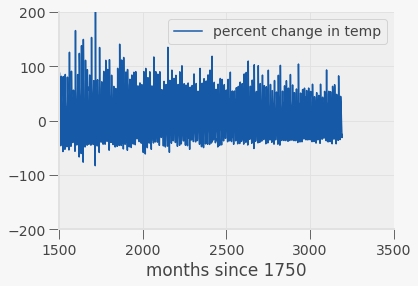

In [10]:
# Create a plot, from the dataframe glob_df, that has y as the percent change of land temperature and x as time.
# Some early values are ommitted due to the high uncertaunty around them and so, the data starts 1500 months after 
#January 1750 so, January 1875.
print('Percent Change of global land temperatures per month since 1750')
glob_df.plot.line(y= 'percent change in temp', ylim = [-200,200], xlim=[1500,3500], xlabel='months since 1750')

In this graph, although an upwards trend in the avergae global land temperature is not clear, there is clearly much less variance in the later points. With additional formatting, this graph may exhibit some interesting relationships that may, perhaps, be relevant to the research.

<AxesSubplot:xlabel='dist from equator'>

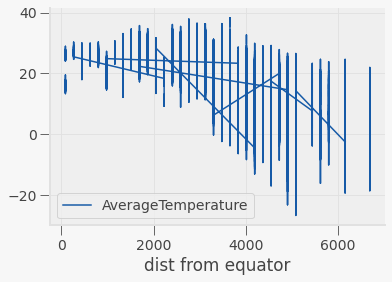

In [11]:
# Create a plot, from the dataframe glob_df, that has y as the p Average land temperature and x as a city's distance
#from the equator in kilometres.
city_df.plot(x='dist from equator', y='AverageTemperature')

Although this plot is a bit difficult to understand at first, it actually provides some useful information. This graoh gives some sort of an indication that land temperatures vary greatly the farther away a city is from the equator. This would make sense since the closer to the Earth's pole a location is, the more likely it is to be affected by climate change. This could also be used to pursue the question of if seasons are getting harsher due to global warming.

array([[<AxesSubplot:title={'center':'percent change in temp'}>]],
      dtype=object)

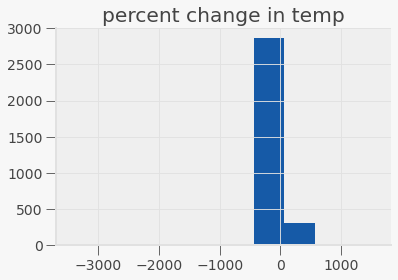

In [12]:
#Create histogram using dataframe glob_df that plots the percent change in the global average tempretature.
#This histogram has a small number of bins so it is easier to read given the numerous outliers that make the plot look
#somewhat odd.
glob_df.hist(column='percent change in temp', bins=10)

This histogram shows that there are far more observation with a negative percent change in tempereature (month over month) than there are positive ones. Again, this visualization would require further investigation to draw out the relationships present in it.

Below is what is to come in the future

## The role that transportation technologies have had in global warming 

## Confounding variables

As is the case with any research, there is always the possibility that there are open backdoor paths or underlying variables that could lead to misleading interpretations of data. This research could face this issue and, as such, this section will identify two possible confounding variables and demonstrate their summary statistics.

1. Governmental Policy

...

# Project 2

# Are global warming and climate change supported by data? What is the relationship between Co2 emissions and the global land temperature? How is the rate of warming different in different places around the world?

Faisal Alkhalili

1004723427

ECO225

## Introduction

This research project aims to use records of the average land temperatures around the world categorized globally, by country, and by city to investigate whether climate change and global warming are supported by data. Additional data that will be used is Co2 emissions data. There will also be a focus on the warming effect of Co2 emissions which translate to pollution. Essentially, this research will look at how the rate of the rise of land temperatures has generally changed over since 1750 and if these changes correspond to changes in the emission of Co2. Also, this report will examine if the rate of warming is different in different cities as well as if the oceans are warming faster than land.

The data that will be used is sourced from Berkeley Earth, an agency that has made several archives of environmental data avialable. The data contains monthly land temperature recordings that begin in 1750. After the year 1850, the data started included maximum and minimum values for each month. Some subsets of the data contain the monthly land temperature values categorized according to the country, city, major city, and US state. It's important to consider that this data begins around the same time that the Industrial Revolution is thought to have started. This is generally considered as the time that industrial pollution began to have seriously adverse effects on the climate and the temperature of the Earth. The additional data, Co2 emissions, is sourced from World Bank. This data will corespond to the level of pollution around the world. The dataset includes Co2 emissions categorized by country including a subset that contains cumulative global Co2 emissions. The outcome that is being considered in this research is the change in the average land temperature and the two main independent variables are pollution generally (which is essentially represented by Co2 emissions) and location.

## Raw Data

In [1]:
data_url = "https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data"

In [43]:
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm #for linear regression: sm.ols
import geopandas as gpd

from shapely.geometry import Point

from pandas_datareader import DataReader

%matplotlib inline
#activate plot theme
import qeds
qeds.themes.mpl_style();
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
! pip install bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json
from bokeh.palettes import OrRd


Loading BokehJS ...

In [4]:
#Reading the first dataset, Global average land temperatures.
glob_land_temp = pd.read_csv('~/Desktop/School/UofT/Third Year/ECO225/ECO225 Project 1/GlobalTemperatures.csv')

In [5]:
#Turning the first dataset into a dataframe. The data is cleaned by dropping irrelevant columns.
glob_df = pd.DataFrame(glob_land_temp)
glob_df = glob_df.drop(['LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 
                        'LandMinTemperature', 'LandAndOceanAverageTemperatureUncertainty', 
                        'LandMinTemperatureUncertainty','LandAndOceanAverageTemperature'], axis=1)
glob_df

,dt,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573
...,...,...
3187,2015-08-01,14.755
3188,2015-09-01,12.999
3189,2015-10-01,10.801
3190,2015-11-01,7.433


The table above represents the raw data for the average global land temperature, per month, since 1750. This is going to be this research's main source of information for the global average land temperature.

In [6]:
#Creating a new column in the dataframe glob_df that finds the percent change 
#in the average global land temperature, month over month.
glob_df['percent change in temp'] = glob_df['LandAverageTemperature'].pct_change()
glob_df['percent change in temp'] = glob_df['percent change in temp'] * 100
glob_df['percent change in temp'] = glob_df['percent change in temp'].round(2)
#Changing the average temperature from monthly intervals to yearly intervals to combine with emissions dataframe
glob_df['dt'] = pd.to_datetime(glob_df['dt'])
glob_df = glob_df.set_index('dt')
glob_df.resample('YS').mean()
glob_df.rename(columns={'LandAverageTemperature': 'Land Average Temperature (˚C)'}, inplace=True)





In [7]:
#Creating a new dataframe that contains the global co2 emissions for each country. This dataframe also has a row
#labeled "World" with the global emissions data
co2 = pd.read_csv('~/Desktop/School/Uoft/Third Year/ECO225/ECO225 Project 1/co2_emission.csv')
co2_df = pd.DataFrame(co2)
co2_df['Year'] = pd.to_datetime(co2_df['Year'], format='%Y')
co2_df

#Creating another dataframe that takes global Co2 emissions and is merged with global average land temperatures
world_co2_df = co2_df[co2_df["Entity"] == "World"]
temp_co2 = glob_df.merge(world_co2_df,right_on='Year', left_on='dt', how='right')
temp_co2


,Land Average Temperature (˚C),percent change in temp,Entity,Code,Year,Annual CO₂ emissions (tonnes )
0,2.495,-9.99,World,OWID_WRL,1751-01-01,9.350528e+06
1,0.348,-96.74,World,OWID_WRL,1752-01-01,9.354192e+06
2,2.039,-59.91,World,OWID_WRL,1753-01-01,9.354192e+06
3,1.574,181.57,World,OWID_WRL,1754-01-01,9.357856e+06
4,1.067,-76.74,World,OWID_WRL,1755-01-01,9.361520e+06
...,...,...,...,...,...,...
262,3.685,-10.17,World,OWID_WRL,2013-01-01,3.520789e+10
263,3.732,-21.00,World,OWID_WRL,2014-01-01,3.550583e+10
264,3.881,-19.98,World,OWID_WRL,2015-01-01,3.546275e+10
265,NaN,NaN,World,OWID_WRL,2016-01-01,3.567510e+10


In [8]:
#Reading the second dataset, monthly average land temperatures by major city. 
#The data is cleaned and irrelevant columns are dropped.
city_land_temp = pd.read_csv('~/Desktop/School/Uoft/Third Year/ECO225/ECO225 Project 1/GlobalLandTemperaturesByMajorCity.csv')
city_df = pd.DataFrame(city_land_temp)
city_df = city_land_temp.drop(['AverageTemperatureUncertainty', 'Longitude'], axis=1)
city_df.rename(columns={'AverageTemperature': 'City Average Temperature (˚C)'}, inplace=True)
city_df.set_index('City')

,dt,City Average Temperature (˚C),Country,Latitude
City,,,,
Abidjan,1849-01-01,26.704,Côte D'Ivoire,5.63N
Abidjan,1849-02-01,27.434,Côte D'Ivoire,5.63N
Abidjan,1849-03-01,28.101,Côte D'Ivoire,5.63N
Abidjan,1849-04-01,26.140,Côte D'Ivoire,5.63N
Abidjan,1849-05-01,25.427,Côte D'Ivoire,5.63N
...,...,...,...,...
Xian,2013-05-01,18.979,China,34.56N
Xian,2013-06-01,23.522,China,34.56N
Xian,2013-07-01,25.251,China,34.56N


The above table includes the land temperature, per month, for each major city around the world. This data will help show differences in the rate of the change of land temperatures around the world. It will be used to identify any relationship between a city's distance from the equator and the change in its land temperature.

In [9]:
#Create a new column in city_df that measures the percent change in temperature month over month
city_df['percent change in temp'] = city_df['City Average Temperature (˚C)'].pct_change(fill_method = 'ffill')
city_df['percent change in temp'] = city_df['percent change in temp'] * 100
city_df['percent change in temp'] = city_df['percent change in temp'].round(2)
#Find the distance of each city from the equator by multiplying the degrees portion of its latitude by 111.045 km.
city_df['dist from equator (km)'] = city_df['Latitude']
city_df['dist from equator (km)'] = city_df['dist from equator (km)'][:-1]
city_df['dist from equator (km)'] = city_df['dist from equator (km)'].replace({'N': '', 'S': ''}, regex=True)
city_df['dist from equator (km)'] = pd.to_numeric(city_df['dist from equator (km)']) * 111.045
city_df.set_index('City')

,dt,City Average Temperature (˚C),Country,Latitude,percent change in temp,dist from equator (km)
City,,,,,,
Abidjan,1849-01-01,26.704,Côte D'Ivoire,5.63N,NaN,625.18335
Abidjan,1849-02-01,27.434,Côte D'Ivoire,5.63N,2.73,625.18335
Abidjan,1849-03-01,28.101,Côte D'Ivoire,5.63N,2.43,625.18335
Abidjan,1849-04-01,26.140,Côte D'Ivoire,5.63N,-6.98,625.18335
Abidjan,1849-05-01,25.427,Côte D'Ivoire,5.63N,-2.73,625.18335
...,...,...,...,...,...,...
Xian,2013-05-01,18.979,China,34.56N,51.07,3837.71520
Xian,2013-06-01,23.522,China,34.56N,23.94,3837.71520
Xian,2013-07-01,25.251,China,34.56N,7.35,3837.71520


The above table includes additional information about the average land temperature for each major city.
It adds the percent change in the temperature month over month as well as each city's distance from the equator in km.

## Summary Statistics

In [10]:
glob_df.describe().round(2)

,Land Average Temperature (˚C),percent change in temp
count,3180.00,3191.00
mean,8.37,7.06
std,4.38,113.31
min,-2.08,-3439.81
25%,4.31,-23.83
50%,8.61,-1.49
75%,12.55,31.42
max,19.02,1568.39


The table above includes a summary statistic of the dataframe glob_df. It computes different statistical values that may be important to the research.

In [11]:
city_df.describe().round(2)

,City Average Temperature (˚C),percent change in temp,dist from equator (km)
count,228175.00,239176.00,239176.00
mean,18.13,NaN,3126.13
std,10.02,NaN,1559.17
min,-26.77,-inf,88.84
25%,12.71,-10.58,2052.11
50%,20.43,-0.02,3302.48
75%,25.92,9.70,4195.28
max,38.28,inf,6692.68


The table above includes a summary statistic of the dataframe city_df. It computes different statistical values that may be important to the research.

## Visual Representations

Text(0.5, 1.0, 'Annual avg land temp vs. Co2 emissions')

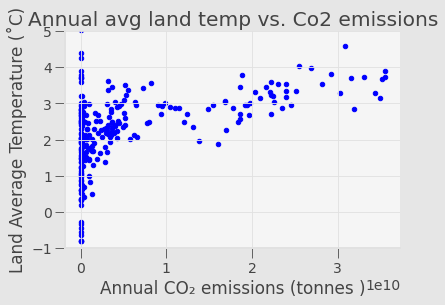

In [12]:
# Create a plot, from the dataframe glob_df, that has y as the percent change of land temperature and x as time.
# Some early values are ommitted due to the high uncertaunty around them and so, the data starts 1500 months after 
#January 1750 so, January 1875.

fig, ax = plt.subplots()
temp_co2.plot(
    kind = 'scatter', x='Annual CO₂ emissions (tonnes )', y= 'Land Average Temperature (˚C)', color='b',
    legend = False, ax=ax, ylim=[-1, 5]
)

ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.9, 0.9, 0.9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Annual avg land temp vs. Co2 emissions")


This scatter plot demonstrates the relationship between the average temperature of the Earth compared to Co2 emissions. Although there are many points that lie close to 0 (which is likely due to some countries not reporting their emissions until recently), the positive relationship is clear! When global Co2 emissions are higher, a higher global land temperature is observed.

<AxesSubplot:title={'center':'City Average Temperature (˚C)'}, xlabel='dist from equator (km)'>

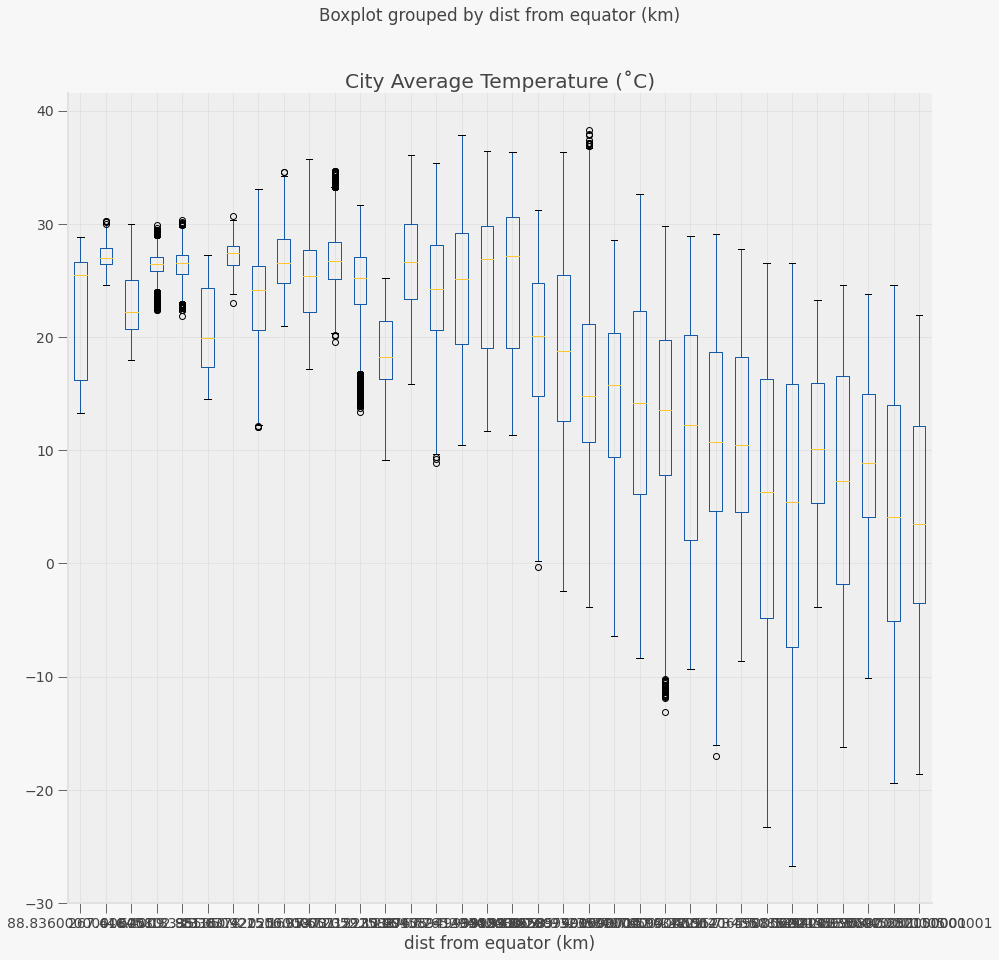

In [14]:
# Create a boxplot, from the dataframe city_df, that has the p Average land temperature by a city's distance
#from the equator in kilometres.
city_df.boxplot('City Average Temperature (˚C)', by='dist from equator (km)', figsize=(15,15))

This boxplot demonstrates that the interquartile range lies closer to the maximum value than the minimum. This shows that, coupled with the graph titled "Diff in city and global temp vs dist from equator", there is more variance in the temperatures of cities further away from the equator. This is shown by the difference in the maximum and minimum values and the interquartile ranges.

Although it is not easy to read the ticks on the x-axis, it is still clear what message the graph is trying to send and that does not take away from its values.

Text(0.5, 1.0, 'Pct Change in Global Land Temp since 1750')

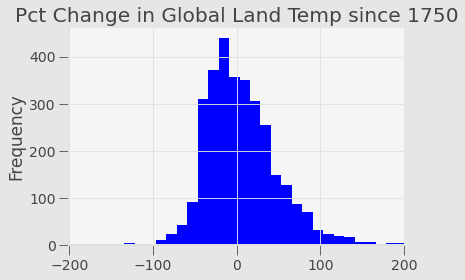

In [15]:
#Create histogram using dataframe glob_df that plots the percent change in the global average tempretature.
   
fig, ax = plt.subplots()
glob_df.plot(
    kind = 'hist', y='percent change in temp', color='b',
    bins = 400, legend = False, density = False, ax=ax, xlim=(-200,200)
)

ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.9, 0.9, 0.9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Pct Change in Global Land Temp since 1750")

This histogram shows that there are  more observation with a negative percent change in tempereature (month over month) than there are positive ones. This means that there are more months where the average global land temperature went down than months where it went up. However, it seems as if the months that had a negative percent change had values that were closer to zero compared to months where the percent change was positive.

## The Message

The main question being investigated in this report is, as stated earlier:
    

Does data about the land temperature support claims about global warming? Are Co2 emissions related to any changes in the temperature of the land? If the data supports global warming, are some areas of the globe warming faster than others?


Thus far, although there is no definitive answer, the data I'm exploring demonstrates that there is evidence to back up the claim that the Earth is warming and that global warming is a reality. Also, my visualizations show that the average land temperature is rising and there is a positive relationship between the land temperature and Co2 emissions. Additionally, the visualizations I've created and the ones that will follow this portion show that there is a relatively even warming of the Earth with no geographic location warming especially faster than another.

Here are some more visual representations I would like to create:

![Caption](https://i.postimg.cc/FR4bLN7K/IMG-9196.png)

![Caption](https://i.postimg.cc/WzKwtrZB/IMG-9197.png)

## Additional Visual Representations

In [16]:
#Creating first visual representations by merging glob_df and city_df dataframes and adding a column that contains
#The difference between a city's average temperature and the global average temperature in 2010

#First, I will convert all dates to datetime format
city_df['dt'] = pd.to_datetime(city_df['dt'])

#Merge glob_df and city_df and find difference in global and city temp
glob_city = glob_df.merge(city_df, left_on='dt', right_on='dt')
glob_city['temp difference (˚C)'] = glob_city['Land Average Temperature (˚C)'] - \
        glob_city['City Average Temperature (˚C)']
glob_city_2010 = glob_city[glob_city['dt'] == '2010-01-01']
glob_city_2010
glob_city_2010.drop(['Latitude','percent change in temp_x','percent change in temp_y'], axis=1)

,dt,Land Average Temperature (˚C),City Average Temperature (˚C),City,Country,dist from equator (km),temp difference (˚C)
233715,2010-01-01,3.737,28.270,Abidjan,Côte D'Ivoire,625.18335,-24.533
233716,2010-01-01,3.737,18.390,Addis Abeba,Ethiopia,981.63780,-14.653
233717,2010-01-01,3.737,20.969,Ahmadabad,India,2588.45895,-17.232
233718,2010-01-01,3.737,8.779,Aleppo,Syria,4016.49765,-5.042
233719,2010-01-01,3.737,16.259,Alexandria,Egypt,3481.26075,-12.522
...,...,...,...,...,...,...,...
233810,2010-01-01,3.737,2.608,Tokyo,Japan,4016.49765,1.129
233811,2010-01-01,3.737,-7.137,Toronto,Canada,4908.18900,10.874
233812,2010-01-01,3.737,25.325,Umm Durman,Sudan,1695.65715,-21.588
233813,2010-01-01,3.737,5.478,Wuhan,China,3302.47830,-1.741


Text(0.5, 1.0, 'Diff in city and global temp vs dist from equator')

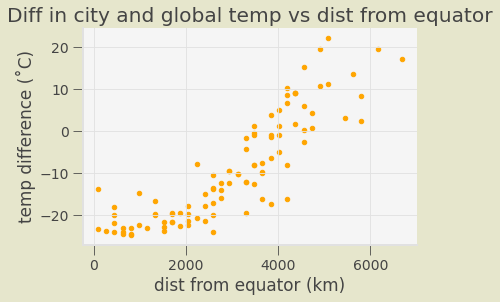

In [17]:
#Create lineplot with temp difference as the y variable and distance from the equator as the x axis.
fig, ax = plt.subplots()
glob_city_2010.plot(
    kind = 'scatter',x='dist from equator (km)', y='temp difference (˚C)', color='orange',
    legend = False, ax=ax,
)

ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.9, 0.9, 0.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Diff in city and global temp vs dist from equator")

After creating a line plot, it was clear that a scatter plot would be more appropriate for this date. This graph is rather informative. It helps answer the part of the message that examines if different parts of the world are warming at different rates. Cities that were far away and close to the equator had average land temperatures that were much higher than those somewhat far away. This makes sense because those that are a bit far away from the equator have average temperatures that are close to the global average. However, these scatter points have a quadratic tendency and there is some heterogeneity.

In [18]:
#I will recreate the glob_df dataframe to now include data about the cumulative land and ocean temperatures
glob_data = pd.read_csv('~/Desktop/School/UofT/Third Year/ECO225/ECO225 Project 1/GlobalTemperatures.csv')

In [19]:
#Create new dataframe land_ocean_df that includes the Average land temperature and the global land and ocean 
#temperature
land_ocean_df = pd.DataFrame(glob_land_temp)
land_ocean_df = land_ocean_df.drop(['LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 
                        'LandMinTemperature', 'LandAndOceanAverageTemperatureUncertainty', 
                        'LandMinTemperatureUncertainty'], axis=1)
land_ocean_df.rename(columns={'LandAverageTemperature': 'Land Average Temperature (˚C)', \
                              'LandAndOceanAverageTemperature': 'Land and Ocean Avg Temp (˚C)'}, inplace=True)
land_ocean_df

,dt,Land Average Temperature (˚C),Land and Ocean Avg Temp (˚C)
0,1750-01-01,3.034,NaN
1,1750-02-01,3.083,NaN
2,1750-03-01,5.626,NaN
3,1750-04-01,8.490,NaN
4,1750-05-01,11.573,NaN
...,...,...,...
3187,2015-08-01,14.755,17.589
3188,2015-09-01,12.999,17.049
3189,2015-10-01,10.801,16.290
3190,2015-11-01,7.433,15.252


This table includes the global average land temperature as well as the global average cumulative land and ocean temperatures.

Text(0.5, 1.0, 'Land temp vs. land and ocean temp')

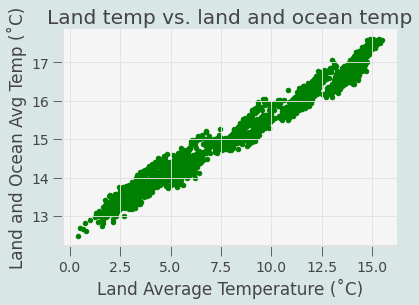

In [20]:
#Create lineplot with Land Average Temperature as the x variable and Land and Ocean Avg Temp as the y axis.
fig, ax = plt.subplots()
land_ocean_df.plot(
    kind = 'scatter',x='Land Average Temperature (˚C)', y='Land and Ocean Avg Temp (˚C)', color='g',
    legend = False, ax=ax,
)

ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.85, 0.9, 0.9))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Land temp vs. land and ocean temp")

This graph did not give the result that was expected. It demonstrates the relationship between the temperature of the land and the temperature of the land and oceans. Clearly, adding the ocean temp to the land temperature, when plotted against just the land tempretaure, shows a relationship that seems linear. This tells us that, on average, the ocean temperature increases similarly to the land tempretaure.

In [56]:
#Read and clean new dataset that contains Land Temperatures by country
cntry_land_temp = pd.read_csv('~/Desktop/School/UofT/Third Year/ECO225/ECO225 Project 1/GlobalLandTemperaturesByCountry.csv')

cntry_df = pd.DataFrame(cntry_land_temp)
cntry_df = cntry_df.drop(['AverageTemperatureUncertainty'], axis = 1)
cntry_df.rename(columns={'AverageTemperature': 'Country Average Temperature (˚C)'}, inplace=True)

temp_1850 = cntry_df[cntry_df['dt'] == '1850-07-01']

In [24]:
#Read file with world map information and add geometric information to dataframe with land temperature
#according to country
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
world.loc['USA' ,'name'] = 'United States'
world.loc['COD', 'name'] ='Congo (Democratic Republic Of The)'

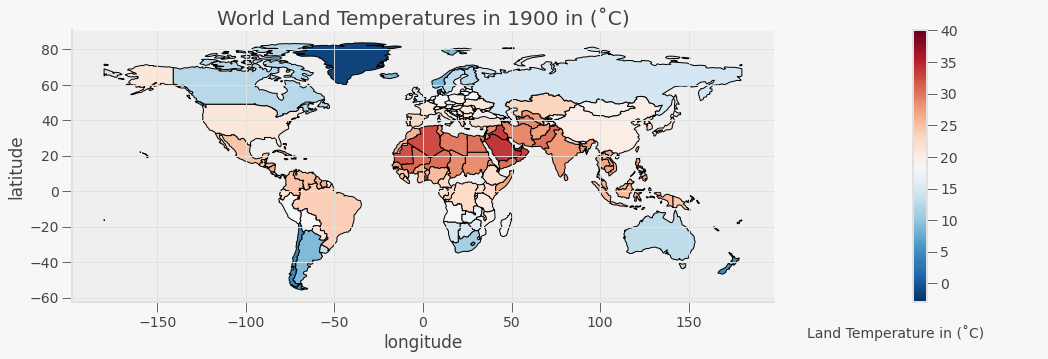

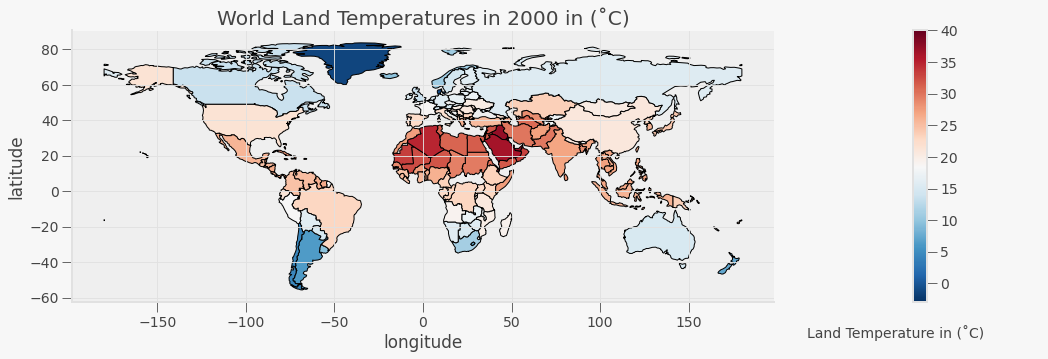

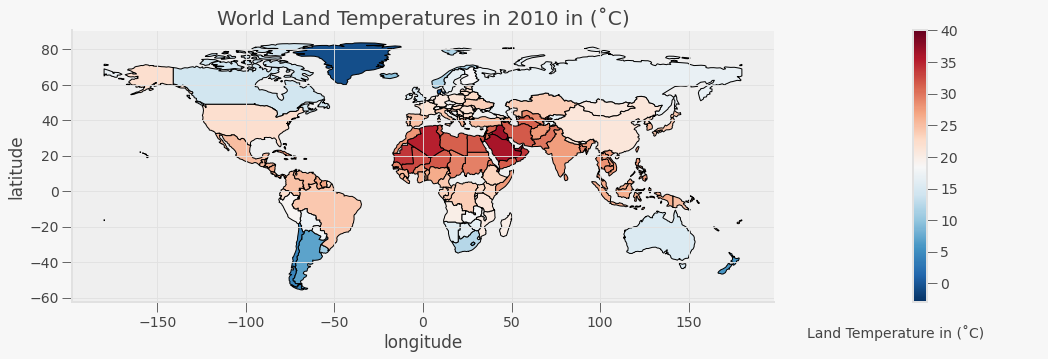

In [25]:
#Plot world map of countries with their color corresponsing to their land temperature in July, 1900

temp_1900 = cntry_df[cntry_df['dt'] == '1900-07-01']
world_1900 = world.merge(temp_1900, left_on = "name", right_on = "Country", how="left")
fig, gax = plt.subplots(figsize=(50,5))

#Plotting the Countries with colors according to land temperatures
world_1900.plot(
    ax=gax, edgecolor='black', column='Country Average Temperature (˚C)', legend=True, cmap='RdBu_r', 
    vmin=-3, vmax=40 #range of your column value for the color legend
)

# Format axes and title
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('World Land Temperatures in 1900 in (˚C)')
gax.annotate('Land Temperature in (˚C)', xy=(0.77, 0.06), xycoords='figure fraction')


# Removing spines
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

#Plot world map of countries with their color corresponsing to their land temperature in July, 2000

temp_2000 = cntry_df[cntry_df['dt'] == '2000-07-01']
world_2000 = world.merge(temp_2000, left_on = "name", right_on = "Country", how="left")
fig, gax = plt.subplots(figsize=(50,5))

#Plotting the Countries with colors according to land temperatures
world_2000.plot(
    ax=gax, edgecolor='black', column='Country Average Temperature (˚C)', legend=True, cmap='RdBu_r', 
    vmin=-3, vmax=40 #range of your column value for the color legend
)

# Format axes and title
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('World Land Temperatures in 2000 in (˚C)')
gax.annotate('Land Temperature in (˚C)', xy=(0.77, 0.06), xycoords='figure fraction')


# Removing spines
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

#Plot world map of countries with their color corresponsing to their land temperature in July, 2010

temp_2010 = cntry_df[cntry_df['dt'] == '2010-07-01']
world_2010 = world.merge(temp_2010, left_on = "name", right_on = "Country", how="left")
fig, gax = plt.subplots(figsize=(50,5))

#Plotting the Countries with colors according to land temperatures
world_2010.plot(
    ax=gax, edgecolor='black', column='Country Average Temperature (˚C)', legend=True, cmap='RdBu_r', 
    vmin=-3, vmax=40 #range of your column value for the color legend
)

# Format axes and title
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('World Land Temperatures in 2010 in (˚C)')
gax.annotate('Land Temperature in (˚C)', xy=(0.77, 0.06), xycoords='figure fraction')

# Removing spines
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()


These three maps are colour coded according to each country's average land temperature in July 1900, 2000, and 2010 respectively. The aim of these maps is to demonstrate how each country's average temperature changed over time and, although the differences in the shades of each country are slight, the fact that there are any difference at all is significant.

In [55]:
co2_1900 = co2_df[co2_df['Year']== '1900']
temp_co2_1900 = co2_1900.merge(temp_1900, left_on='Entity', right_on='Country', how='right')
temp_co2_1900.rename(columns={'Country Average Temperature (˚C)': 'Country temp'}, inplace=True)

In [54]:
temp_co2_geojson=GeoJSONDataSource(geojson=temp_co2_1900.to_json())

color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 0, high = 1)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('Country','@country'),
                              ('Annual CO₂ emissions (tonnes)', '@Annual CO₂ emissions (tonnes )'),
                               ('Avg Temperature (˚C)','@Country Average Temperature (˚C)')])
v = figure(title="Wisconsin Voting in 2016 Presidential Election", tools=[hover])
v.patches("xs","ys",source=temp_co2_geojson,
          fill_color = {'field' :'Country Average Temperature (˚C)', 'transform' : color_mapper})
v.add_layout(color_bar, 'below')
show(v)

#I attempted to make an interactive map but couldn't. I will keep this code to attempt to debug for the future. If you
#have any tips on how to fix this and then include it in the next project, that would be greatly appreciated!

## New Dataset

In this project, compared to the last one, I added a new major dataset that contains Co2 emissions. After all, it is difficult to have any discussion of global warming and climate change without considering carbon dioxide emissions. This new dataset helped me refine my message and allowed me to create new, more intuitive, and more useful graphs that help me respond to my question more directly.

## Conclusion

To conclude, the question I am trying to answer is if data about the temperature of the Earth supports the claim that there is global warming. Also, part of my question is whether or not Co2 emissions are associated with an increasing global land temperature. My findings thus far, which are demonstrated in the visualizations, support the claim that the Earth is steadily warming. The strongest evidence in favor of this hypothesis is that there is a positive relationship between Co2 emissions and the temperature of the Earth. 

My maps also support this hypothesis, although the differences in the shades of each country are slight the fact that there is a difference is significant. It is widely accepted that even slight changes in the temperature of the Earth have catastrophic events on the environment and warrants that there is an overhaul in the way we live life. Global warming is a serious problem and this data supports its existence. It is difficult to doubt the effect that pollution has on our environemnt after considering these visualizations.